# PGA Success Predictor

## Imports and Installations

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd 'drive/MyDrive/Cal Poly SLO/Graduate Program/CSC 570 (2)/Team Project'
%ls

In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from pylab import rcParams
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [4]:
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor

In [5]:
from data.data_handler import import_dataset

## Data Processing
Player Name is used as an index (as it should be used as an identifier and not a feature) and all values are scaled with Min-Max in case data is not a normal distribution

In [6]:
X, y = import_dataset('data/pgaTourData.csv', split_train_test=False, numpy_format=False)
names = X['Player Name']
X.index = names
y.index = names
X = X.drop(['Player Name'], axis=1)
features = X.columns
scaler = MinMaxScaler()
X = pd.DataFrame(scaler.fit_transform(X), index=names, columns=features)
Xy = X.join(y)
Xy.dropna()
Xy.index.name = None
Xy = Xy.sample(frac=1)
Xy

,Rounds,Fairway Percentage,Avg Distance,gir,Average Putts,Average Scrambling,Average Score,Points,Wins,Average SG Putts,Average SG Total,SG:OTT,SG:APR,SG:ARG,Top 10
Sean O'Hair,0.520000,0.498819,0.577861,0.633133,0.444126,0.533570,0.368818,0.168987,0.0,0.607294,0.646661,0.614928,0.559602,0.521384,1.0
Charlie Wi,0.546667,0.550207,0.360225,0.307808,0.209169,0.597156,0.350579,0.215554,0.0,0.673321,0.621906,0.474703,0.451603,0.855346,3.0
Scott Stallings,0.426667,0.384525,0.637899,0.481481,0.535817,0.401264,0.550158,0.159626,0.2,0.449136,0.451647,0.578389,0.454093,0.406918,1.0
Danny Lee,0.573333,0.579740,0.454034,0.576076,0.300860,0.663507,0.438092,0.114738,0.0,0.626104,0.581834,0.537789,0.474634,0.616981,4.0
Martin Laird,0.506667,0.643828,0.557223,0.604104,0.404011,0.668641,0.307261,0.161546,0.0,0.663340,0.715939,0.609619,0.566138,0.712579,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Ryan Blaum,0.480000,0.628766,0.424015,0.628629,0.464183,0.452212,0.402490,0.103217,0.0,0.575816,0.565628,0.539663,0.499844,0.588050,2.0
Jason Bohn,0.520000,0.704962,0.251407,0.713213,0.498567,0.532385,0.378464,0.221555,0.2,0.616123,0.648085,0.561836,0.623716,0.520126,3.0
Dustin Johnson,0.400000,0.369462,0.962477,0.676176,0.275072,0.546603,0.155559,0.411666,0.2,0.615355,0.830632,0.836040,0.703081,0.451572,12.0
William McGirt,0.706667,0.657413,0.397749,0.691191,0.449857,0.661532,0.297264,0.325732,0.2,0.704415,0.742119,0.651780,0.602552,0.566667,2.0


## Feature Extraction
Heatmap is used to see which features are most correlated with the prediction column (Top 10). In this case, we see that Average Score, Average SG Total, and Points are the most indicative of being good features for Top 10 results. 

In [7]:
def plot_correlation(data):
    fig, ax = plt.subplots(figsize=(20, 15))
    sns.heatmap(data.corr(), linewidths=.3, annot=True, fmt=".2f")
    plt.show()
    fig.savefig('corr.png')

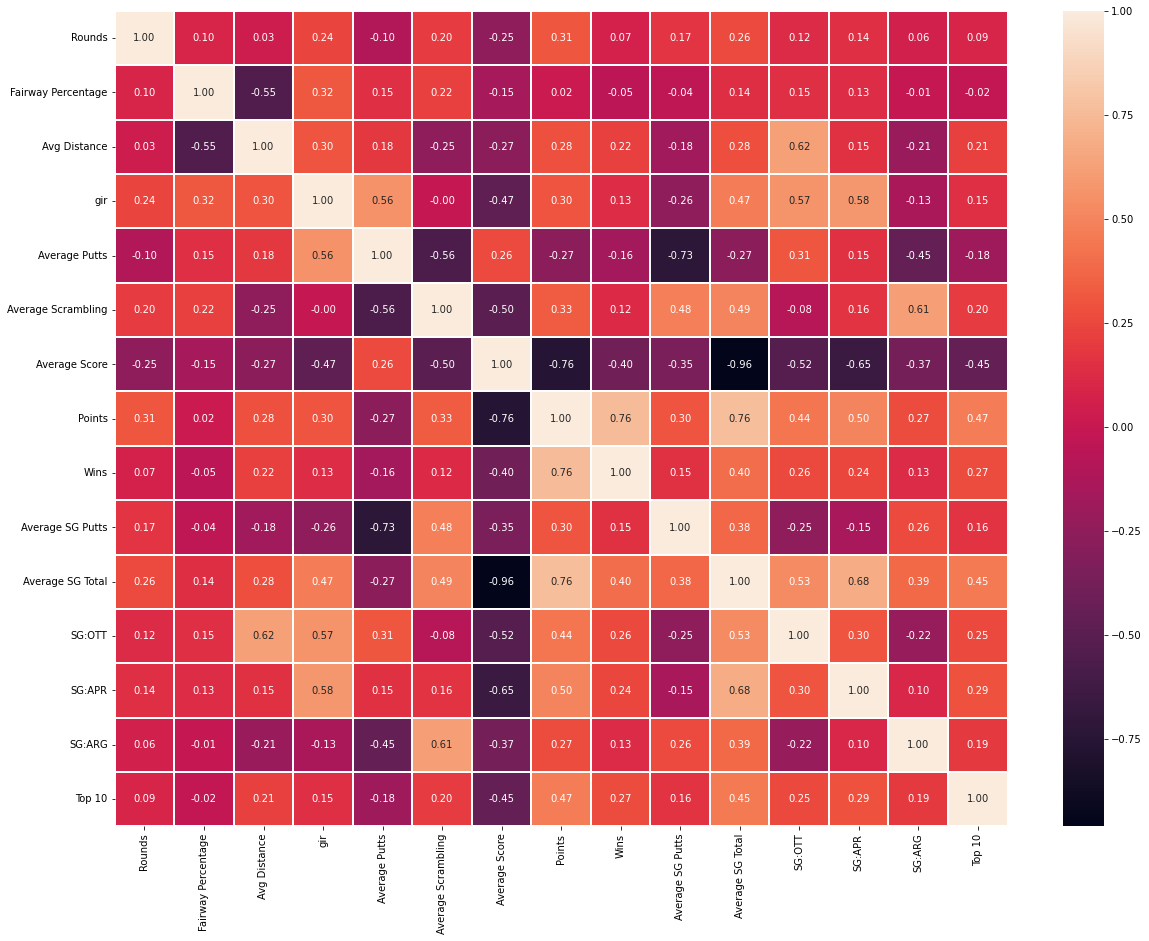

In [8]:
plot_correlation(Xy)

## Feature Selection
Selecting Average Score, Average SG Total, and Points are selected to be used as the features to train regression models due to correlation with Top 10.

In [9]:
X = Xy[['Average Score', 'Average SG Total', 'Points']]
X

,Average Score,Average SG Total,Points
Sean O'Hair,0.368818,0.646661,0.168987
Charlie Wi,0.350579,0.621906,0.215554
Scott Stallings,0.550158,0.451647,0.159626
Danny Lee,0.438092,0.581834,0.114738
Martin Laird,0.307261,0.715939,0.161546
...,...,...,...
Ryan Blaum,0.402490,0.565628,0.103217
Jason Bohn,0.378464,0.648085,0.221555
Dustin Johnson,0.155559,0.830632,0.411666
William McGirt,0.297264,0.742119,0.325732


In [10]:
y = Xy[['Top 10']]
y

,Top 10
Sean O'Hair,1.0
Charlie Wi,3.0
Scott Stallings,1.0
Danny Lee,4.0
Martin Laird,2.0
...,...
Ryan Blaum,2.0
Jason Bohn,3.0
Dustin Johnson,12.0
William McGirt,2.0


In [11]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.20, random_state=0)

## Regression Model Performances

In [12]:
def plot_regression(ytest, ypred):
    fig, ax = plt.subplots()
    ax.scatter(ypred, ytest, edgecolors=(0, 0, 1))
    ax.plot([ytest.min(), ytest.max()], [ytest.min(), ytest.max()], 'r--', lw=3)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    plt.show()

In [13]:
def calculate_error(ytest, ypred):
    mae = mean_absolute_error(ytest, ypred)
    mse = mean_squared_error(ytest, ypred)
    r2 = r2_score(ytest, ypred)
    print("The model performance for testing set")
    print("--------------------------------------")
    print('MAE is {}'.format(mae))
    print('MSE is {}'.format(mse))
    print('R2 score is {}'.format(r2))

### SVM 

c:\Users\kamen\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The model performance for testing set
--------------------------------------
MAE is 1.3917279201622148
MSE is 3.4185220170769197
R2 score is 0.22879766121940037


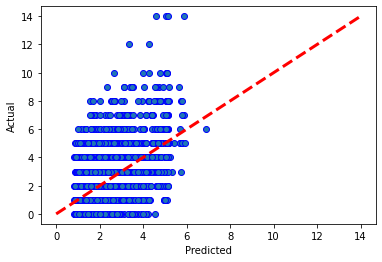

In [14]:
svm_reg = SVR(kernel='rbf')
svm_reg.fit(Xtrain,ytrain)
ypred = svm_reg.predict(Xtest)
calculate_error(ytest, ypred)
plot_regression(ytest, ypred)


# Save model to pickle file
file = open('models/SVM.pkl', 'wb')
pickle.dump(svm_reg, file)
file.close()

### Random Forest

C:\Users\kamen\AppData\Local\Temp/ipykernel_14516/1152017608.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_reg.fit(Xtrain,ytrain)


The model performance for testing set
--------------------------------------
MAE is 1.4168638027752878
MSE is 3.3872093558537064
R2 score is 0.2358616489451355


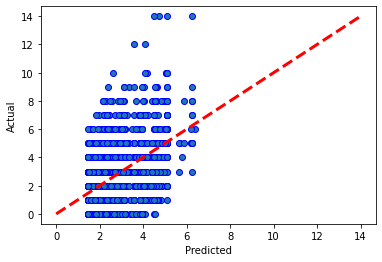

In [15]:
rf_reg = RandomForestRegressor(max_depth=3, random_state=0)
rf_reg.fit(Xtrain,ytrain)
ypred = rf_reg.predict(Xtest)
calculate_error(ytest, ypred)
plot_regression(ytest, ypred)


# Save model to pickle file
file = open('models/RandomForestRegressor', 'wb')
pickle.dump(rf_reg, file)
file.close()

### Linear Regression

The model performance for testing set
--------------------------------------
MAE is 1.4183754652673728
MSE is 3.3991403700803566
R2 score is 0.23317006877404012


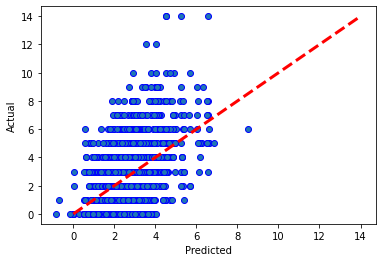

In [16]:
lin_reg = LinearRegression()
lin_reg.fit(Xtrain,ytrain)
ypred = lin_reg.predict(Xtest)
calculate_error(ytest, ypred)
plot_regression(ytest, ypred)

# Save model to pickle file
file = open('models/LinearRegressor.pkl', 'wb')
pickle.dump(lin_reg, file)
file.close()

### Ridge Regression

The model performance for testing set
--------------------------------------
MAE is 1.4184796871660394
MSE is 3.3992978133005396
R2 score is 0.23313455033097508


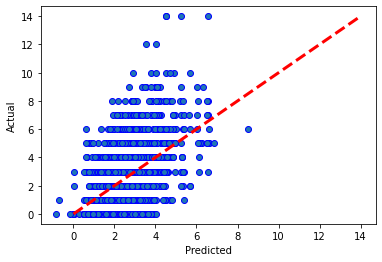

In [17]:
rdg_reg = Ridge(alpha=0.5)
rdg_reg.fit(Xtrain,ytrain)
ypred = rdg_reg.predict(Xtest)
calculate_error(ytest, ypred)
plot_regression(ytest, ypred)


# Save model to pickle file
file = open('models/RidgeRegressor.pkl', 'wb')
pickle.dump(rdg_reg, file)
file.close()

### Decision Tree

The model performance for testing set
--------------------------------------
MAE is 1.4570112673739615
MSE is 3.5175885032577607
R2 score is 0.2064487322214914


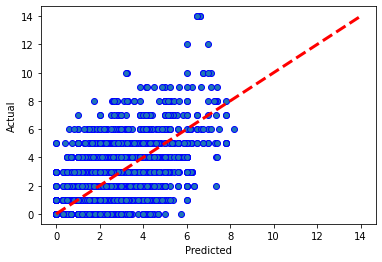

In [18]:
dt_reg = DecisionTreeRegressor(random_state=0)
dt_reg.fit(Xtrain,ytrain)
ypred = dt_reg.predict(Xtest)
calculate_error(ytest, ypred)
plot_regression(ytest, ypred)

# Save model to pickle file
file = open('models/DecisionTree.pkl', 'wb')
pickle.dump(dt_reg, file)
file.close()

### Neural Network Regressor

In [19]:
mlp_reg = MLPRegressor(random_state=0, max_iter=500)
mlp_reg.fit(Xtrain,ytrain)
ypred = mlp_reg.predict(Xtest)
calculate_error(ytest, ypred)
plot_regression(ytest, ypred)

# Save model to pickle file
file = open('models/NN.pkl', 'wb')
pickle.dump(mlp_reg, file)
file.close()

c:\Users\kamen\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1599: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
